# Social Network Analysis

### Libraries

In [2]:
# import libraries

import pandas as pd
import matplotlib.pyplot as plt
import json
import networkx as nx
from networkx.algorithms.community import girvan_newman
import community.community_louvain as louvain

import utils

In [3]:
# major variables

city = 'Sicklerville'

### Helper methods

In [4]:
def generate_graph(nodes, edges):
    '''
    Generate a networkx graph from nodes and edges dataframes
    '''
    G = nx.Graph()
    for _, row in nodes.iterrows():
        G.add_node(row['id'], name=row['name'])
    for _, row in edges.iterrows():
        G.add_edge(row['from'], row['to'], weight=row['weight'], type=row['type'])
    return G

In [5]:
def generate_communities(G, algorithm='girvan_newman'):
    '''
    Generate communities using the specified algorithm
    '''
    if algorithm == 'girvan_newman':
        communities = girvan_newman(G)
        first_iteration_communities = next(communities)
        return first_iteration_communities
    elif algorithm == 'louvain':
        communities = louvain.best_partition(G)
        return communities
    else:
        raise ValueError("Invalid algorithm. Choose 'girvan_newman' or 'louvain'.")

In [6]:
def visualize_graph(G, communities, city, connection):
    '''
    Visualize the graph with nodes colored by community
    '''
    plt.figure(figsize=(12, 5))
    pos = nx.spring_layout(G)
    
    community_colors = {}
    if isinstance(communities, tuple):
        for i, comm_nodes in enumerate(communities):
            for node in comm_nodes:
                community_colors[node] = i
    elif isinstance(communities, dict):
        for node, community_id in communities.items():
            community_colors[node] = community_id
    node_colors = [community_colors[node] for node in G.nodes()]
    
    nx.draw(G, pos,
            node_color=node_colors,
            cmap=plt.cm.tab20,
            node_size=20,
            edge_color='black',
            edgecolors='black',
            width=1,
            with_labels=False)
    
    plt.title(f"{city} - {connection}")
    plt.show()

In [7]:
def store_communities(communities, num_communities=None, filename='communities.json'):
    '''
    Store communities in a JSON file
    '''
    community_data = {"num_communities": num_communities, "communities": []}
    if isinstance(communities, tuple):
        for community_set in communities:
            community_data["communities"].append(list(community_set))
    elif isinstance(communities, dict):
        data = {}
        for node, community_id in communities.items():
            if community_id not in data:
                data[community_id] = []
            data[community_id].append(node)
        for _, nodes in sorted(data.items()):
            community_data["communities"].append(nodes)
    
    else:
        raise ValueError("Unsupported community format. Please provide a tuple of sets or a dictionary.")
    if num_communities is None:
        community_data["num_communities"] = len(community_data["communities"])
    
    with open(filename, 'w') as f:
        json.dump(community_data, f, indent=4)
    print(f"Communities have been stored in {filename}.")

### Friendship connections

In [8]:
# load friendship data

connection = 'friendships'

nodes = pd.read_csv(f'nodes_and_edges/{city}_{connection}_nodes.csv')
edges = pd.read_csv(f'nodes_and_edges/{city}_{connection}_edges.csv')

In [9]:
# generate friendship graph

friendship_graph = generate_graph(nodes, edges)

In [10]:
# generate friendship communities

friendship_communities = generate_communities(friendship_graph, algorithm='girvan_newman')
num_communities = len(friendship_communities)

store_communities(friendship_communities, num_communities, filename=f'communities/{city}_{connection}_communities.json')

Communities have been stored in communities/Sicklerville_friendships_communities.json.


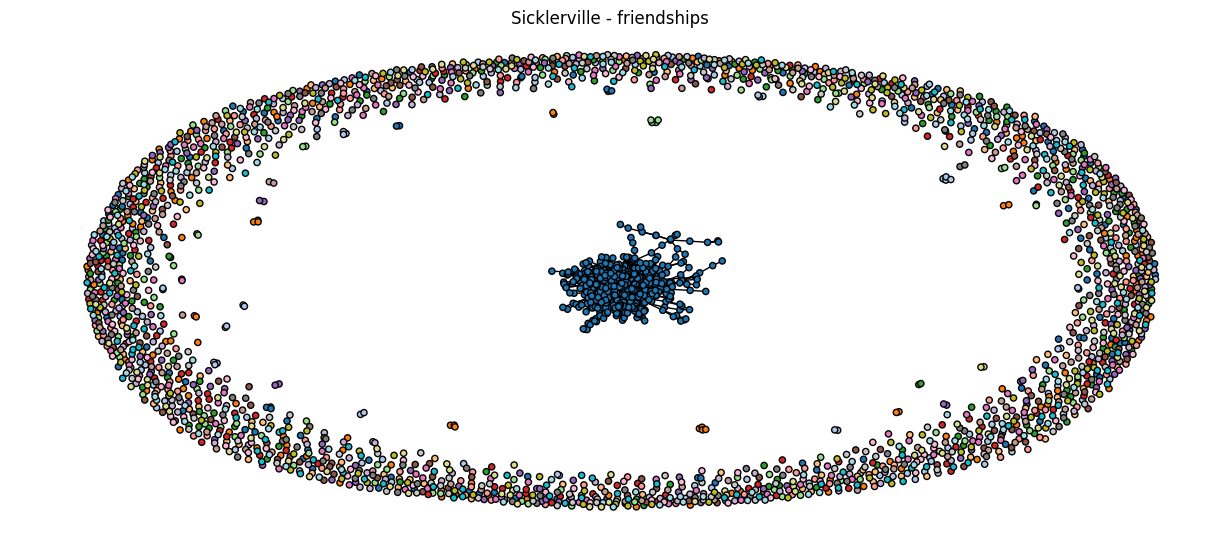

In [11]:
# visualize friendship graph

visualize_graph(friendship_graph, friendship_communities, city, connection)

### Review connections

In [12]:
# load review data

connection = 'business_reviews'

nodes = pd.read_csv(f'nodes_and_edges/{city}_{connection}_nodes.csv')
edges = pd.read_csv(f'nodes_and_edges/{city}_{connection}_edges.csv')

In [13]:
# generate review graph

review_graph = generate_graph(nodes, edges)

In [14]:
# generate review communities

review_communities = generate_communities(review_graph, algorithm='louvain') # girvan_newman is incredibly slow here
num_communities = len(set(review_communities.values()))

store_communities(review_communities, num_communities, filename=f'communities/{city}_{connection}_communities.json')

Communities have been stored in communities/Sicklerville_business_reviews_communities.json.


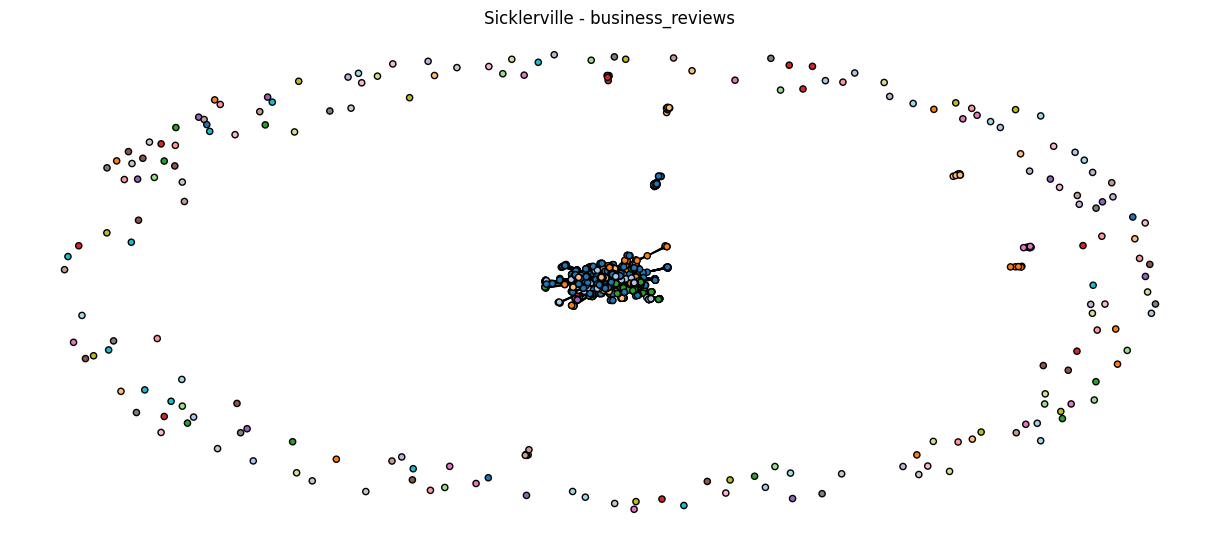

In [15]:
# visualize review graph

visualize_graph(review_graph, review_communities, city, connection)

### Tip connections

In [16]:
# load tip data

connection = 'business_tips'

nodes = pd.read_csv(f'nodes_and_edges/{city}_{connection}_nodes.csv')
edges = pd.read_csv(f'nodes_and_edges/{city}_{connection}_edges.csv')

In [17]:
# generate tip graph

tip_graph = generate_graph(nodes, edges)

In [18]:
# generate tip communities

tip_communities = generate_communities(tip_graph, algorithm='girvan_newman')
num_communities = len(tip_communities)

store_communities(tip_communities, num_communities, filename=f'communities/{city}_{connection}_communities.json')

Communities have been stored in communities/Sicklerville_business_tips_communities.json.


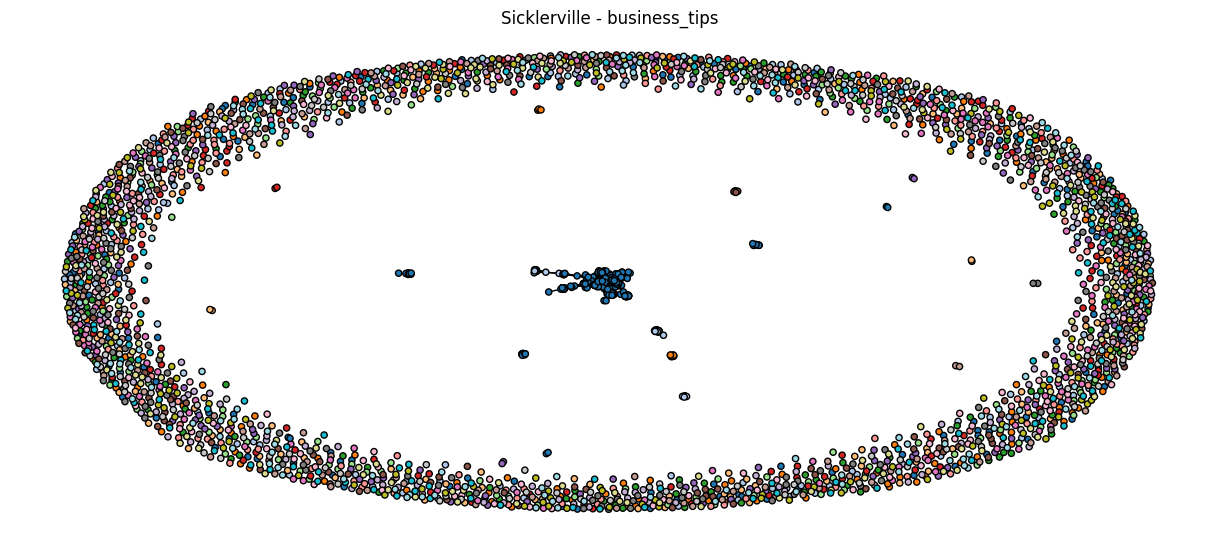

In [19]:
# visualize tip graph

visualize_graph(tip_graph, tip_communities, city, connection)

### Category connections

In [20]:
# load category data

connection = 'categories'

nodes = pd.read_csv(f'nodes_and_edges/{city}_{connection}_nodes.csv')
edges = pd.read_csv(f'nodes_and_edges/{city}_{connection}_edges.csv')

In [21]:
# generate category graph

category_graph = generate_graph(nodes, edges)

In [22]:
# generate category communities

category_communities = generate_communities(category_graph, algorithm='louvain')
num_communities = len(set(category_communities.values()))

store_communities(category_communities, num_communities, filename=f'communities/{city}_{connection}_communities.json')

Communities have been stored in communities/Sicklerville_categories_communities.json.


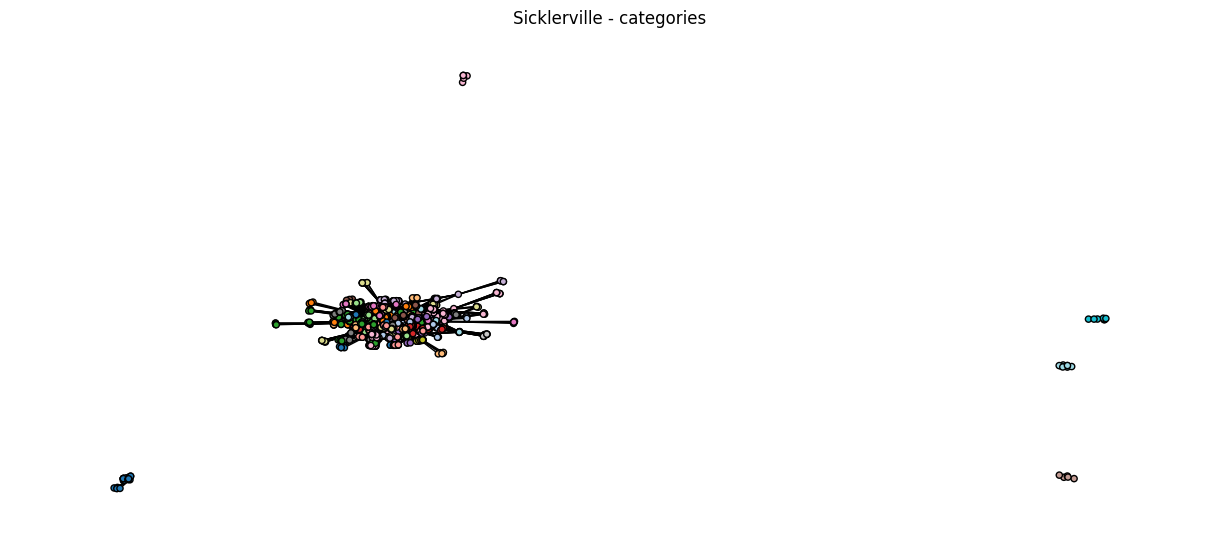

In [23]:
# visualize category graph

visualize_graph(category_graph, category_communities, city, connection)

### Category connections (with threshold)

In [24]:
# load threshold category data

connection = 'threshold_categories'

nodes = pd.read_csv(f'nodes_and_edges/{city}_{connection}_nodes.csv')
edges = pd.read_csv(f'nodes_and_edges/{city}_{connection}_edges.csv')

In [25]:
# generate threshold category graph

threshold_category_graph = generate_graph(nodes, edges)

In [26]:
# generate threshold category communities

threshold_category_communities = generate_communities(threshold_category_graph, algorithm='girvan_newman')
num_communities = len(threshold_category_communities)

store_communities(threshold_category_communities, num_communities, filename=f'communities/{city}_{connection}_communities.json')

Communities have been stored in communities/Sicklerville_threshold_categories_communities.json.


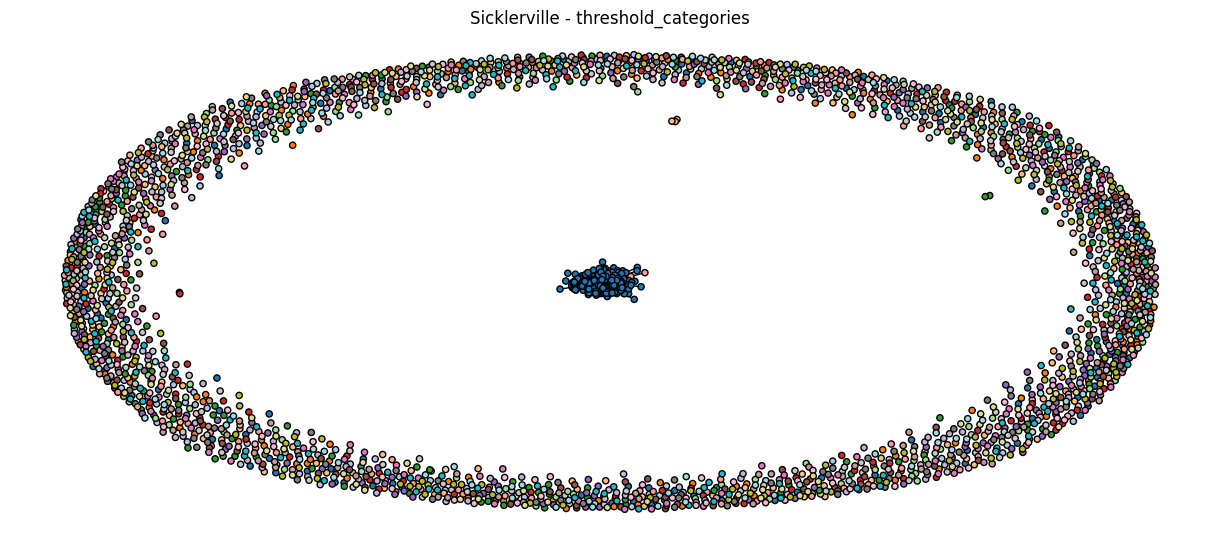

In [27]:
# visualize threshold category graph

visualize_graph(threshold_category_graph, threshold_category_communities, city, connection)

### Combined connections

In [28]:
# load combined data

connection = 'combined'

nodes = pd.read_csv(f'nodes_and_edges/{city}_{connection}_nodes.csv')
edges = pd.read_csv(f'nodes_and_edges/{city}_{connection}_edges.csv')

In [29]:
# generate combined graph

combined_graph = generate_graph(nodes, edges)

In [30]:
# generate combined communities

combined_communities = generate_communities(combined_graph, algorithm='louvain')
num_communities = len(set(combined_communities.values()))

store_communities(combined_communities, num_communities, filename=f'communities/{city}_{connection}_communities.json')

Communities have been stored in communities/Sicklerville_combined_communities.json.


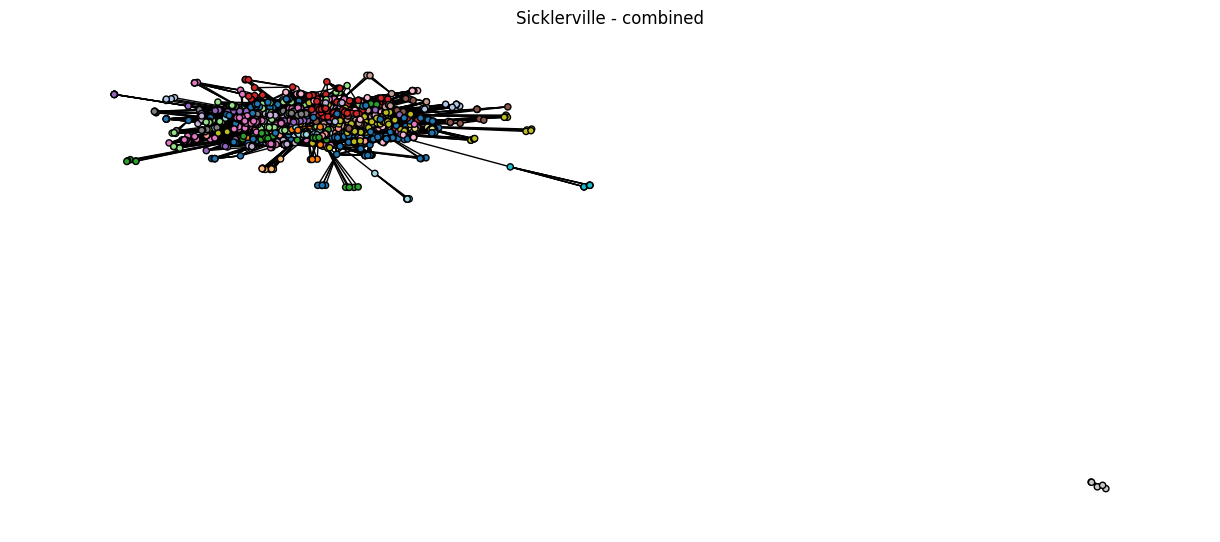

In [31]:
# visualize combined graph

visualize_graph(combined_graph, combined_communities, city, connection)

### Category and business review connections

In [32]:
# load category and review data

connection = 'categories_and_reviews'

nodes = pd.read_csv(f'nodes_and_edges/{city}_{connection}_nodes.csv')
edges = pd.read_csv(f'nodes_and_edges/{city}_{connection}_edges.csv')

In [33]:
# generate category and review graph

category_and_review_graph = generate_graph(nodes, edges)

In [34]:
# generate category and review communities

category_and_review_communities = generate_communities(category_and_review_graph, algorithm='louvain')
num_communities = len(set(category_and_review_communities.values()))

store_communities(category_and_review_communities, num_communities, filename=f'communities/{city}_{connection}_communities.json')

Communities have been stored in communities/Sicklerville_categories_and_reviews_communities.json.


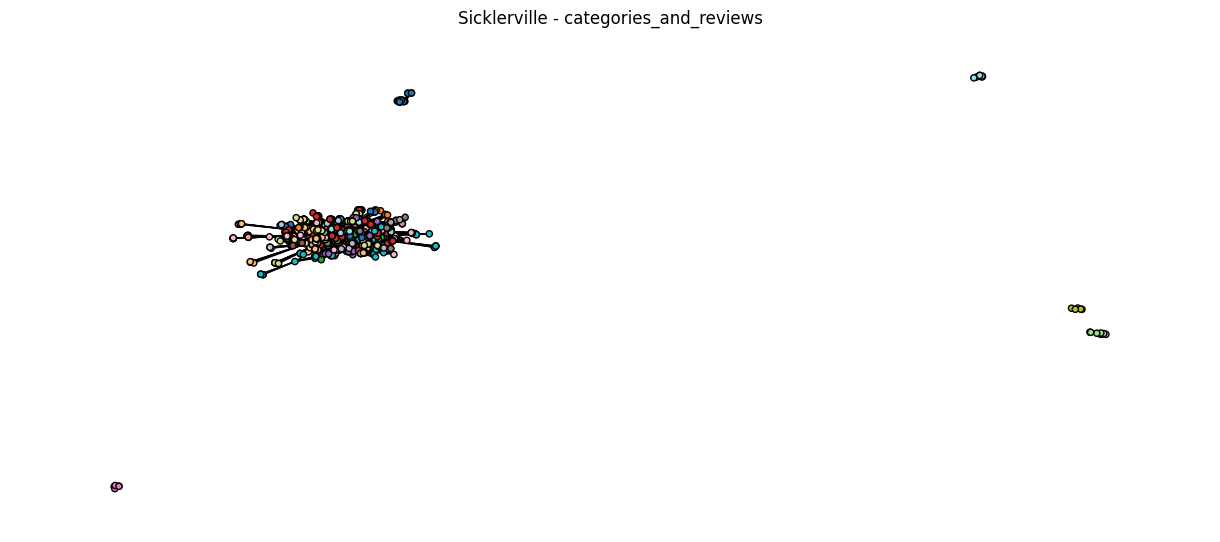

In [35]:
# visualize combined graph

visualize_graph(category_and_review_graph, category_and_review_communities, city, connection)

### Graph statistics

In [36]:
def calculate_density(graph):
    return nx.density(graph)

density_category_graph = calculate_density(category_graph)
density_combined_graph = calculate_density(combined_graph)
density_category_and_review_graph = calculate_density(category_and_review_graph)

print(f"Density of category graph: {density_category_graph:0.4f}")
print(f"Density of combined graph: {density_combined_graph:0.4f}")
print(f"Density of category and review graph: {density_category_and_review_graph:0.4f}")


Density of category graph: 0.0367
Density of combined graph: 0.0371
Density of category and review graph: 0.0367


In [38]:
# graphs diameter

def calculate_average_diameter(graph):
    if nx.is_connected(graph):
        diameter_weighted = nx.diameter(graph, weight='weight')
        print(f"Weighted undirected diameter: {diameter_weighted}")
    else:
        components = nx.connected_components(graph)
        diameters = []
        for i, component in enumerate(components, start=1):
            subgraph = graph.subgraph(component)
            diameter = nx.diameter(subgraph, weight='weight')
            diameters.append(diameter)
        
        average_diameter = sum(diameters) / len(diameters)
        print(f"\nAverage diameter of connected components: {average_diameter}")

print("For category graph:")
calculate_average_diameter(category_graph)

print("\nFor combined graph:")
calculate_average_diameter(combined_graph)

print("\nFor category and review graph:")
calculate_average_diameter(category_and_review_graph)

For category graph:


KeyboardInterrupt: 

In [ ]:
# graph degree distribution

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

def plot_degree_distribution(graph, ax, title, color):
    degrees = dict(nx.degree(graph, weight='weight'))
    ax.hist(degrees.values(), bins=range(1, max(degrees.values()) + 2), alpha=0.75, label=title, color=color)
    ax.set_xlabel('Degree')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Degree Distribution - {title}')
    ax.legend()

plot_degree_distribution(category_graph, axes[0], "Category Graph", 'blue')
plot_degree_distribution(combined_graph, axes[1], "Combined Graph", 'red')
plot_degree_distribution(category_and_review_graph, axes[2], "Category and Review Graph", 'green')

plt.tight_layout()
plt.show()

In [ ]:
# closeness centrality

def compute_closeness(graph):
    if nx.is_weighted(graph):
        closeness = nx.closeness_centrality(graph, distance='weight')
    else:
        closeness = nx.closeness_centrality(graph)
    return closeness

category_closeness = compute_closeness(category_graph)
combined_closeness = compute_closeness(combined_graph)
category_and_review_closeness = compute_closeness(category_and_review_graph)

category_closeness_df = pd.DataFrame({'name': list(category_closeness.keys()), 'closeness': list(category_closeness.values())})
category_closeness_df = category_closeness_df.sort_values(by='closeness', ascending=False)

combined_closeness_df = pd.DataFrame({'name': list(combined_closeness.keys()), 'closeness': list(combined_closeness.values())})
combined_closeness_df = combined_closeness_df.sort_values(by='closeness', ascending=False)

category_and_review_closeness_df = pd.DataFrame({'name': list(category_and_review_closeness.keys()), 'closeness': list(category_and_review_closeness.values())})
category_and_review_closeness_df = category_and_review_closeness_df.sort_values(by='closeness', ascending=False)

print("Category graph closeness centrality:")
print(category_closeness_df)

print("\nCombined graph closeness centrality:")
print(combined_closeness_df)

print("\nCategory and review graph closeness centrality:")
print(category_and_review_closeness_df)

# taking too long to compute (when considering weights)

In [ ]:
# betweenness centrality

def compute_betweenness(graph):
    num_nodes = len(graph.nodes)
    k = min(500, num_nodes)
    
    betweenness = nx.betweenness_centrality(graph, k=k, weight='weight')
    betweenness_df = pd.DataFrame({'name': list(betweenness.keys()), 'betweenness': list(betweenness.values())})
    betweenness_df = betweenness_df.sort_values(by='betweenness', ascending=False)
    
    return betweenness_df

category_betweenness_df = compute_betweenness(category_graph)
combined_betweenness_df = compute_betweenness(combined_graph)
category_and_review_betweenness_df = compute_betweenness(category_and_review_graph)

print("Category graph betweenness centrality:")
print(category_betweenness_df)

print("\nCombined graph betweenness centrality:")
print(combined_betweenness_df)

print("\nCategory and review graph betweenness centrality:")
print(category_and_review_betweenness_df)

# running with a representative sample so it doesn't take forever

In [ ]:
# edge betweenness centrality

def compute_edge_betweenness(graph):
    num_edges = len(graph.edges)
    k = min(500, num_edges)
    
    edge_betweenness = nx.edge_betweenness_centrality(graph, k=k, weight='weight')
    
    return edge_betweenness

category_edge_betweenness = compute_edge_betweenness(category_graph)
combined_edge_betweenness = compute_edge_betweenness(combined_graph)
category_and_review_edge_betweenness = compute_edge_betweenness(category_and_review_graph)

print("Category graph edge betweenness centrality:")
print(category_edge_betweenness)

print("\nCombined graph edge betweenness centrality:")
print(combined_edge_betweenness)

print("\nCategory and review graph edge betweenness centrality:")
print(category_and_review_edge_betweenness)

# running with a representative sample so it doesn't take forever

In [ ]:
# average shortest path length

def compute_average_shortest_path_length(graph):
    if nx.is_connected(graph):
        return nx.average_shortest_path_length(graph, weight='weight')
    else:
        avg_lengths = []
        connected_components = nx.connected_components(graph)
        for component in connected_components:
            component_graph = graph.subgraph(component)
            avg_lengths.append(nx.average_shortest_path_length(component_graph, weight='weight'))
        return sum(avg_lengths) / len(avg_lengths)

print("Average shortest path length for category graph:")
print(compute_average_shortest_path_length(category_graph))

print("\nAverage shortest path length for combined graph:")
print(compute_average_shortest_path_length(combined_graph))

print("\nAverage shortest path length for category and review graph:")
print(compute_average_shortest_path_length(category_and_review_graph))

# taking too long to compute

In [ ]:
# graph homophily

def compute_homophily(graph):
    return nx.degree_assortativity_coefficient(graph, weight='weight')

print("Homophily for category graph:")
print(f"All network = {compute_homophily(category_graph):.3f}")

print("\nHomophily for combined graph:")
print(f"All network = {compute_homophily(combined_graph):.3f}")

print("\nHomophily for category and review graph:")
print(f"All network = {compute_homophily(category_and_review_graph):.3f}")

In [65]:
# Load users and tips
city = 'Sicklerville'

users = pd.read_csv(f'filtered_cities/{city}_user.csv')
tips = pd.read_csv(f'filtered_cities/{city}_tip.csv')

users

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,RgDVC3ZUBqpEe6Y1kPhIpw,Monica,1282,2009-02-23 14:08:31,12640,10005,11149,"2009,2010,2011,2012,2013,2014,2015,2016","sHozd2pcOKwHtPr8VlZJfg, 7mL9cvICl8fuCQTM89a-SA...",804,...,102,108,138,65,898,2584,1731,1731,551,177
1,zkamNMEjihh3zN7lC7_WVw,Matthew,15,2006-02-04 15:53:46,35,4,22,NaN,"YLzb3jjc3p-XAOBRggcrgA, 9lcq01JUhRY2yW8AxU3TIA...",1,...,1,0,0,0,1,3,2,2,0,0
2,gVFxZMcuG_Tal2_TnpmUPg,Stephanie,146,2008-05-05 00:16:33,347,100,124,"2011,2012,2013,2014,2015,2016","uUh_q6rVMhKxwt0eaiphRg, jRqWx2z7jdSzpvqqswqNnw...",6,...,13,1,0,0,10,8,21,21,8,0
3,g0_x4kVvJAYuk96oCcbOmw,Michael,455,2009-04-15 12:46:06,1823,696,663,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2018","_BcWyKQL16ndpBdggh2kNA, mx50KP6rXgutH36fhnL6Vw...",46,...,11,0,1,5,39,33,57,57,32,8
4,-NbeVN5tnwdyYAvdNkKMjw,Dominic,1101,2012-04-25 19:31:00,6704,1959,4179,"2012,2013,2014,2015,2016,2017,2018,2019,20,20,...","9IRuYmy5YmhtNQ6ei1p-uQ, 6NvkQATK0J2nmEWsuzhHig...",193,...,33,18,2,2,312,457,637,637,137,63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3073,CUE13op55l9WZp6fBTUWnA,Nicole,2,2016-08-19 13:24:47,0,0,0,NaN,None,0,...,0,0,0,0,0,0,0,0,0,0
3074,cACn6Qc1owO7hV_ZhcP74Q,Allison,1,2019-11-10 00:05:23,0,0,0,NaN,None,0,...,0,0,0,0,0,0,0,0,0,0
3075,SpTYEhfInvALG1le1uu21w,Ray,2,2016-01-18 16:55:04,5,0,0,NaN,None,0,...,0,0,0,0,0,0,0,0,0,0
3076,sGOCaCP7_SMlaRKPNO__CQ,Tahjae,2,2019-05-04 13:07:23,0,0,0,NaN,None,0,...,0,0,0,0,0,0,0,0,0,0


In [94]:
# Users that ended up alone

def alone_users_stats(connection_temp):
    with open(f'communities/{city}_{connection_temp}_communities.json') as f:
        communities_temp = json.load(f)
        communities_temp = communities_temp['communities']
    
    alone_communities = {i[0] for i in list(filter(lambda x: len(x) == 1, communities_temp))}
    
    users_alone = users[users['user_id'].isin(alone_communities)]
    print("Number of users that ended up alone:")
    print(len(alone_communities), end=" / ")
    print(len(users))
    if len(alone_communities) > 0:
        print("Alone people that have reviewed businesses:")
        reviewed_businesses = len(users_alone[users_alone['review_count'] > 0])
        print(reviewed_businesses, end=" ")
        reviewed_businesses_perc = reviewed_businesses / len(users_alone) * 100
        print(f"({reviewed_businesses_perc:.2f}%)")
        print("Alone people that have written tips:")
        written_tips = len(tips[tips['user_id'].isin(alone_communities)].groupby('user_id'))
        print(written_tips, end=" ")
        written_tips_perc = written_tips / len(users_alone) * 100
        print(f"({written_tips_perc:.2f}%)")
        print("Alone people that have friends:")
        have_friends = len(users_alone[users_alone['friends'].str.len() > 0])
        print(have_friends, end=" ")
        have_friends_perc = have_friends / len(users_alone) * 100
        print(f"({have_friends_perc:.2f}%)")
        print("Alone people that have fans:")
        have_fans = len(users_alone[users_alone['fans'] > 0])
        print(have_fans, end=" ")
        have_fans_perc = have_fans / len(users_alone) * 100
        print(f"({have_fans_perc:.2f}%)")
        print("Alone people that have compliments:")
        have_compliments = len(users_alone[users_alone['compliment_hot'] > 0])
        print(have_compliments, end=" ")
        have_compliments_perc = have_compliments / len(users_alone) * 100
        print(f"({have_compliments_perc:.2f}%)")
        print("Min-Max unused users:")
        print(f"{min(reviewed_businesses_perc, written_tips_perc, have_friends_perc, have_fans_perc, have_compliments_perc):.2f}%", end=" - ")
        print(f"{max(reviewed_businesses_perc, written_tips_perc, have_friends_perc, have_fans_perc, have_compliments_perc):.2f}%")
    print("Information about alone users:")
    return users_alone

In [95]:
alone_users_stats('friendships')

Number of users that ended up alone:
2258 / 3078
Alone people that have reviewed businesses:
2258 (100.00%)
Alone people that have written tips:
284 (12.58%)
Alone people that have friends:
2258 (100.00%)
Alone people that have fans:
365 (16.16%)
Alone people that have compliments:
96 (4.25%)
Min-Max unused users:
4.25% - 100.00%
Information about alone users:


,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
2,gVFxZMcuG_Tal2_TnpmUPg,Stephanie,146,2008-05-05 00:16:33,347,100,124,"2011,2012,2013,2014,2015,2016","uUh_q6rVMhKxwt0eaiphRg, jRqWx2z7jdSzpvqqswqNnw...",6,...,13,1,0,0,10,8,21,21,8,0
7,SQ2J0vy4sUIrVfB6_qcbDg,Windi,501,2009-02-27 21:52:47,2791,2055,1638,2009,"O4HaIHYvOzeGUpH-YiLijg, u4t0wqjJ-xkZ0iJu48jkXw...",107,...,58,54,90,35,232,398,446,446,97,73
8,kZnSGYEx0mLVGroGtZiXIA,Ms. Edna,772,2009-05-30 19:32:30,1394,584,904,"2010,2011","lpvpL2z51kxOWWEJtILueQ, hizGc5W1tBHPghM5YKCAtg...",54,...,5,2,6,12,66,34,60,60,10,32
12,LI_A-_R6SQotk6fX8C0nPQ,Susan,24,2011-10-05 01:47:59,26,13,2,NaN,"bdxH5-FGyJyHhajhO0K6cw, vIyNRqrIE7dh4HQsZZRfWg...",0,...,0,0,0,0,0,1,0,0,0,0
13,CBk3GqDIhAxm1Sm5uWZynA,AhBeng,17,2008-09-10 03:34:01,52,27,16,NaN,"idbX4epRgkw3dQGn44Eyfw, qWsVrZeVB5fmbv9CcmP5pw...",7,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3073,CUE13op55l9WZp6fBTUWnA,Nicole,2,2016-08-19 13:24:47,0,0,0,NaN,None,0,...,0,0,0,0,0,0,0,0,0,0
3074,cACn6Qc1owO7hV_ZhcP74Q,Allison,1,2019-11-10 00:05:23,0,0,0,NaN,None,0,...,0,0,0,0,0,0,0,0,0,0
3075,SpTYEhfInvALG1le1uu21w,Ray,2,2016-01-18 16:55:04,5,0,0,NaN,None,0,...,0,0,0,0,0,0,0,0,0,0
3076,sGOCaCP7_SMlaRKPNO__CQ,Tahjae,2,2019-05-04 13:07:23,0,0,0,NaN,None,0,...,0,0,0,0,0,0,0,0,0,0


In [96]:
alone_users_stats('business_reviews')

Number of users that ended up alone:
188 / 3078
Alone people that have reviewed businesses:
188 (100.00%)
Alone people that have written tips:
188 (100.00%)
Alone people that have friends:
188 (100.00%)
Alone people that have fans:
52 (27.66%)
Alone people that have compliments:
32 (17.02%)
Min-Max unused users:
17.02% - 100.00%
Information about alone users:


,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
9,NEnjlrr2ozU4FMmXup88wA,Denise,119,2009-01-14 17:17:57,187,54,60,"2014,2015","MOHhPWRk2aLVOeWtrzRYPg, sGt1R_nmq_Ne-FgOsIQCvQ...",14,...,3,0,2,0,5,18,4,4,3,0
14,vWWvICTldmZgz-JMui2u2w,Mikey,23,2010-10-17 12:40:17,47,11,8,NaN,"eSlOI3GhroEtcbaD_nFXJQ, TVQTgxQ0SUNYRX4rPsnINw...",4,...,3,0,0,0,3,2,1,1,2,1
21,bi76Ih6tRv-ghYWFCJ0dag,Trent,151,2010-08-16 11:39:49,72,19,34,"2019,20,20,2021","jc5KTjRMwRfg_lDenUbAqQ, dkT1690AnF68CxZYAkZ91g...",12,...,0,0,0,0,13,6,2,2,1,2
22,9C_h-H1Z7Xz7dvbgsBrnSg,Kurt,669,2010-04-21 17:32:42,1243,819,478,"2011,2012,2013,2014,2015,2016,2017,2018,2019,2...","jkdBrZGG20x1jEG5BcGWHQ, 6woTWCjHDMEjQclniEei-A...",44,...,7,1,2,1,46,32,41,41,16,10
38,302kcRtUp1vNds8tN3tr6Q,Stephen,39,2010-02-06 23:56:48,67,15,12,NaN,"KESnVopFWtANLc_-iPcK2w, nmzVWZSuznrZG6vob8drnA...",1,...,1,0,0,0,1,1,2,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2986,GGQBfgKMS3qdqvvZDt4C5w,Lisa,2,2018-11-29 17:08:14,0,0,0,NaN,None,0,...,0,0,0,0,0,0,0,0,0,0
2990,ZQnJI8dy7_KB-K5SYXHWWQ,Natasha,2,2016-08-06 22:54:09,0,0,0,NaN,None,0,...,0,0,0,0,0,0,0,0,0,0
3016,wScYRsGUOVV6_P-xASARqg,Stephen,1,2015-12-27 17:04:38,2,1,0,NaN,None,0,...,0,0,0,0,0,0,0,0,0,0
3024,EcpuvYCa8W7z2UEHQ4z1Dg,Stephanie,2,2013-12-31 19:51:00,1,0,1,NaN,None,0,...,0,0,0,0,0,0,0,0,0,0


In [97]:
alone_users_stats('business_tips')

Number of users that ended up alone:
2666 / 3078
Alone people that have reviewed businesses:
2666 (100.00%)
Alone people that have written tips:
24 (0.90%)
Alone people that have friends:
2666 (100.00%)
Alone people that have fans:
645 (24.19%)
Alone people that have compliments:
279 (10.47%)
Min-Max unused users:
0.90% - 100.00%
Information about alone users:


,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,RgDVC3ZUBqpEe6Y1kPhIpw,Monica,1282,2009-02-23 14:08:31,12640,10005,11149,"2009,2010,2011,2012,2013,2014,2015,2016","sHozd2pcOKwHtPr8VlZJfg, 7mL9cvICl8fuCQTM89a-SA...",804,...,102,108,138,65,898,2584,1731,1731,551,177
2,gVFxZMcuG_Tal2_TnpmUPg,Stephanie,146,2008-05-05 00:16:33,347,100,124,"2011,2012,2013,2014,2015,2016","uUh_q6rVMhKxwt0eaiphRg, jRqWx2z7jdSzpvqqswqNnw...",6,...,13,1,0,0,10,8,21,21,8,0
4,-NbeVN5tnwdyYAvdNkKMjw,Dominic,1101,2012-04-25 19:31:00,6704,1959,4179,"2012,2013,2014,2015,2016,2017,2018,2019,20,20,...","9IRuYmy5YmhtNQ6ei1p-uQ, 6NvkQATK0J2nmEWsuzhHig...",193,...,33,18,2,2,312,457,637,637,137,63
5,cXtE-ZTrNx-hE7usp_f_xg,Marie,125,2010-05-16 17:46:19,424,192,319,"2010,2011","ekxji4rVD27afI38LbJbSw, aGI_wfhcJ86DJ-67Lkty8g...",22,...,0,2,2,0,12,21,39,39,15,4
6,X6ikCQsAC4QGN-RjmvW2vA,J.,24,2007-10-06 15:11:37,59,16,26,NaN,"f3AZHdFgVpB5oglDz4kvyQ, ulRdB25JWcztx_n6N67yog...",2,...,2,0,0,0,1,0,2,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3073,CUE13op55l9WZp6fBTUWnA,Nicole,2,2016-08-19 13:24:47,0,0,0,NaN,None,0,...,0,0,0,0,0,0,0,0,0,0
3074,cACn6Qc1owO7hV_ZhcP74Q,Allison,1,2019-11-10 00:05:23,0,0,0,NaN,None,0,...,0,0,0,0,0,0,0,0,0,0
3075,SpTYEhfInvALG1le1uu21w,Ray,2,2016-01-18 16:55:04,5,0,0,NaN,None,0,...,0,0,0,0,0,0,0,0,0,0
3076,sGOCaCP7_SMlaRKPNO__CQ,Tahjae,2,2019-05-04 13:07:23,0,0,0,NaN,None,0,...,0,0,0,0,0,0,0,0,0,0


In [98]:
alone_users_stats('categories')

Number of users that ended up alone:
0 / 3078
Information about alone users:


,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos


In [99]:
alone_users_stats('threshold_categories')

Number of users that ended up alone:
2592 / 3078
Alone people that have reviewed businesses:
2592 (100.00%)
Alone people that have written tips:
283 (10.92%)
Alone people that have friends:
2592 (100.00%)
Alone people that have fans:
589 (22.72%)
Alone people that have compliments:
266 (10.26%)
Min-Max unused users:
10.26% - 100.00%
Information about alone users:


,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,RgDVC3ZUBqpEe6Y1kPhIpw,Monica,1282,2009-02-23 14:08:31,12640,10005,11149,"2009,2010,2011,2012,2013,2014,2015,2016","sHozd2pcOKwHtPr8VlZJfg, 7mL9cvICl8fuCQTM89a-SA...",804,...,102,108,138,65,898,2584,1731,1731,551,177
4,-NbeVN5tnwdyYAvdNkKMjw,Dominic,1101,2012-04-25 19:31:00,6704,1959,4179,"2012,2013,2014,2015,2016,2017,2018,2019,20,20,...","9IRuYmy5YmhtNQ6ei1p-uQ, 6NvkQATK0J2nmEWsuzhHig...",193,...,33,18,2,2,312,457,637,637,137,63
5,cXtE-ZTrNx-hE7usp_f_xg,Marie,125,2010-05-16 17:46:19,424,192,319,"2010,2011","ekxji4rVD27afI38LbJbSw, aGI_wfhcJ86DJ-67Lkty8g...",22,...,0,2,2,0,12,21,39,39,15,4
7,SQ2J0vy4sUIrVfB6_qcbDg,Windi,501,2009-02-27 21:52:47,2791,2055,1638,2009,"O4HaIHYvOzeGUpH-YiLijg, u4t0wqjJ-xkZ0iJu48jkXw...",107,...,58,54,90,35,232,398,446,446,97,73
8,kZnSGYEx0mLVGroGtZiXIA,Ms. Edna,772,2009-05-30 19:32:30,1394,584,904,"2010,2011","lpvpL2z51kxOWWEJtILueQ, hizGc5W1tBHPghM5YKCAtg...",54,...,5,2,6,12,66,34,60,60,10,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3073,CUE13op55l9WZp6fBTUWnA,Nicole,2,2016-08-19 13:24:47,0,0,0,NaN,None,0,...,0,0,0,0,0,0,0,0,0,0
3074,cACn6Qc1owO7hV_ZhcP74Q,Allison,1,2019-11-10 00:05:23,0,0,0,NaN,None,0,...,0,0,0,0,0,0,0,0,0,0
3075,SpTYEhfInvALG1le1uu21w,Ray,2,2016-01-18 16:55:04,5,0,0,NaN,None,0,...,0,0,0,0,0,0,0,0,0,0
3076,sGOCaCP7_SMlaRKPNO__CQ,Tahjae,2,2019-05-04 13:07:23,0,0,0,NaN,None,0,...,0,0,0,0,0,0,0,0,0,0


In [100]:
alone_users_stats('combined')

Number of users that ended up alone:
0 / 3078
Information about alone users:


,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos


In [101]:
alone_users_stats('categories_and_reviews')

Number of users that ended up alone:
0 / 3078
Information about alone users:


,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
